In [277]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [28]:
full_dataset = pd.read_csv('archive/Loan_status_2007-2020Q3.gzip')

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
full_dataset.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [214]:
small_dataset = full_dataset[-100000:]

In [254]:
columns = ['annual_inc', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'funded_amnt', 
           'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'pub_rec',
           'pub_rec_bankruptcies', 'revol_bal', 'term', 'total_acc', 'verification_status', 'loan_status']
df = small_dataset[columns]


In [255]:
df['loan_status'].unique()

array(['Current', 'Charged Off', 'Fully Paid', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [256]:
def normalize(X):
    X = X.dropna()
    X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
    X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
    X['term'] = [float(re.sub('[a-zA-Z ]*', '', str(string))) for string in X['term']]
    X['home_ownership'] = (X['home_ownership'] == 'OWN').astype('int')
    X['verification_status'] = (X['verification_status'] != 'Verified') | (X['verification_status'] != 'Source Verified')
    X['verification_status'] = X['verification_status'].astype('int')
    # Remove emp title, issue_d before regression is run
    # Drop funded amount since it is equal to loan amount (Makes matrix singular)
    X = X.drop(columns=['emp_title', 'issue_d','funded_amnt'])
    
    X['loan_status'] = (X['loan_status'] == 'Current') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'In Grace Period')
    X['loan_status'] = X['loan_status'].astype('int')
    return X
  


In [257]:
df = normalize(df)


/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [269]:
X = df.drop(columns=['loan_status'])
Y = df['loan_status']
log_reg = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.416454
         Iterations 6


In [270]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                93522
Model:                          Logit   Df Residuals:                    93506
Method:                           MLE   Df Model:                           15
Date:                Thu, 06 May 2021   Pseudo R-squ.:                 0.05703
Time:                        23:33:14   Log-Likelihood:                -38948.
converged:                       True   LL-Null:                       -41303.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
annual_inc                 2.58e-06   2.53e-07     10.217      0.000    2.09e-06    3.08e-06
chargeoff_within_12_mths    -0.0170      0.086     -0.198      0.843      -0.186       0.152
delinq_2yrs                 -0.0267      0.009     -2.914      0.004      -0.045      -0.009
dti                         -0.0026      0.001     -3.472      0.001      -0.004      -0.001
emp_length                   0.0122      0.003      4.754      0.000       0.007       0.017
home_ownership               0.0220      0.030      0.739      0.460      -0.036       0.080
inq_last_6mths              -0.1360      0.011    -12.552      0.000      -0.157      -0.115
installment                 -0.0007      0.000     -3.558      0.000      -0.001      -0.000
int_rate                    -0.0845      0.003    -33.237      0.000      -0.090      -0.080
loan_amnt                 8.752e-06   6.45e-06      1.356      0.175    -3.9e-06    2.14e-05
pub_rec                     -0.0459      0.017     -2.765      0.006      -0.078      -0.013
pub_rec_bankruptcies        -0.0824      0.028     -2.962      0.003      -0.137      -0.028
revol_bal                  2.87e-06   5.92e-07      4.851      0.000    1.71e-06    4.03e-06
term                        -0.0074      0.002     -3.834      0.000      -0.011      -0.004
total_acc                    0.0006      0.001      0.665      0.506      -0.001       0.002
verification_status          3.1852      0.063     50.856      0.000       3.062       3.308
============================================================================================
"""

In [ ]:
X = df.drop(columns=['loan_status'])
Y = df['loan_status']
model = LogisticRegression()
model.fit(X, Y)

In [268]:
model.coef_

array([[ 5.62469167e-06, -5.22602077e-05, -1.60177933e-03,
         1.20849822e-02,  4.15066669e-02,  1.01388216e-03,
        -1.09221898e-02,  4.57804720e-03, -1.16146233e-01,
        -1.65042109e-04, -2.32398960e-03, -1.50501512e-03,
         1.59617476e-08,  5.45904472e-02,  1.61095232e-02,
         7.38405097e-03]])

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


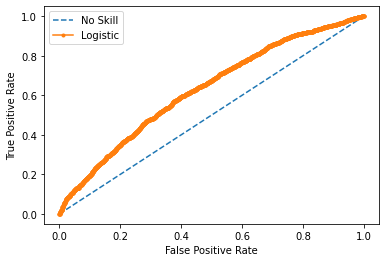

In [278]:
validation_set = full_dataset[-110000:-100000]
validation_df = validation_set[columns]
validation_df = normalize(validation_df)
X_test = validation_df.drop(columns=['loan_status'])
y_test = validation_df['loan_status']
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()